# Exploring the EM Algorithm 

> **tl;dr:** I explain, visualize, and code the EM Algorithm for Gaussian Mixture Models and explain how it is basically just an example of Variational Inference.

In my AMLED class we recently talked about how Maximum Likelihood can help you find the best statistical model:

1. Write down the formula for the Likelihood of the data $P(\mathbf{X})$. This is how likely the data are with respect to your probabilistic models parameters.
2. Take that likelihood, and take the natural logarithm of it. This won't change the optimal parameters that maximize the likelihood, since the logarithm is a monotonically increasing function.
3. Take that log-likelihood, and optimize it, typically by setting the partial derivatives of the log-likelihood w.r.t. each parameter equal to 0 and solving for which parameters get you that.

A typical example of this is [finding the $\mu$ and $\sigma$ of a Gaussian Distribution](https://en.wikipedia.org/wiki/Maximum_likelihood#Continuous_distribution.2C_continuous_parameter_space).

This works fine for certain convex likelihoods (provided you are careful to take care of things like singularities, ill-conditioned matrices, etc.). However, for many types of models this optimization is not straight-forward: the optimal parameters depend on one another in complex, non-linear ways, and you can't just "plug-in" the right data to get the optimal answer. One case where this occurs is in Latent Variable models, such as [Gaussian Mixture Models](https://en.wikipedia.org/wiki/Mixture_model#Gaussian_mixture_model), that is, where you have data that are generated from multiple gaussian distributions, but you don't know which distribution generated which data point. While this might seem similar to the MLE of the Gaussian Distribution above, it is actually much more complex.

One way to solve this problem is by first finding a "simpler" distribution, for which analytical closed form updates are possible, and then matching that simpler distribution as closely as possible to the "harder" distribution. This is the basic idea behind [Variational Inference](https://en.wikipedia.org/wiki/Variational_Bayesian_methods). Often, one can iteratively update simpler models to get closer and closer to the "harder" one. That iteration between simplier models is the basic idea of the [Expectation-Maximization Algorithm](https://en.wikipedia.org/wiki/Expectation%E2%80%93maximization_algorithm). And in some cases, with certain models and distributions, that iterative process of inching closer and close with simpler distributions can actually get you the exact solution to the harder distribution that you originally wanted. Below, we will see that Gaussian Mixture Models are one case where that happens. Most of the time, however, you will not be so lucky and the optimized simple models will be a little different than what an optimized hard model would be; in these cases you just hope that the diffence doesn't affect actual performance much.



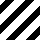
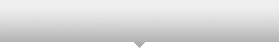
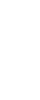
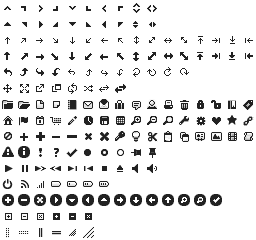
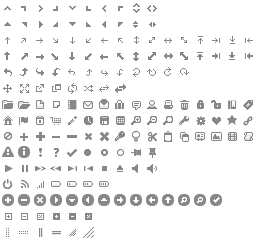
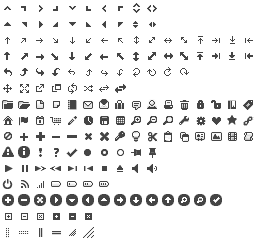
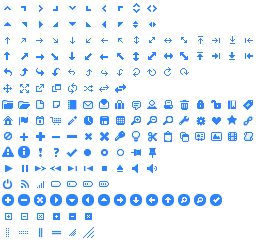
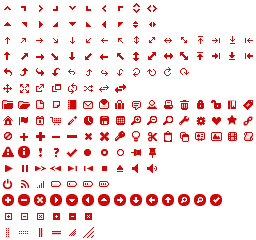
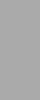
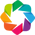
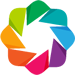
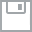
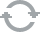
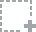
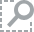
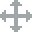
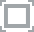
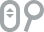

In [1]:
# First, let's just setup the libraries we'll need
from scipy.stats import norm
from scipy.stats import entropy
from bokeh.plotting import figure, output_notebook, show
from bokeh.models import ColumnDataSource
from ipywidgets import interact
import numpy as np
plot_height = 400
plot_width = 800
# output to the IPython Notebook
output_notebook()

## Problem Setup - Gaussian Mixture Models
As mentioned above, the basic idea is that you have $N$ data points that are actually drawn from $K$ different Gaussian distributions. We don't know which data point was drawn from which distribution, or what these distributions are: where each ($k$) is centered ($\mu_k$), or what its standard deviation ($\sigma_k$) is. To make things even a little trickier, we also don't know how many of the $N$ points are from which distribution! Maybe 90% of the points come from one distribution, and 10% come from the others; we don't know. So we also want to figure out, for each ($k$) distribution, what fraction of the data comes from that distribution ($\pi_k$).

## So what does this look like?
Before we get into the details of the model, let's just see what the problem and data look like:

In [2]:
# Draw points from actual Gaussians
N = 10000 # This is the number of data points
K = 2 # We'll only do 2 Gaussians

### First Gaussian ###
mu_1 = 3
s_1 = 0.5
### Second Gaussian ###
mu_2 = 5
s_2 = 1

# Relative frequency of the gaussians
pi1 = 1
pi2 = 2 # The second will produce twice as many data points
pi_total = pi1+pi2
pi1 /= pi_total # Normalize
pi2 /= pi_total # Normalize
# Make an analytical gaussian with scipi.stats
g1 = norm(loc = mu_1, scale = s_1)
g2 = norm(loc = mu_2, scale = s_2)
# Now "mix" the two: this shows us the joint PDF of the mixture
gm = lambda x: pi1*g1.pdf(x)+pi2*g2.pdf(x)

# Plot the actual Probability Density Function (PDF) curve
xp = np.linspace(0, 10, 1000)
p = figure(title="Gaussian Mixtures", x_axis_label='x', y_axis_label='p(x)',
           plot_height = plot_height, plot_width = plot_width)
# Plot the first gaussian - lighter line
p.line(xp,g1.pdf(xp),legend="p1(x)",  line_width=2, alpha =0.3)
# Second gaussian - lighter line
p.line(xp,g2.pdf(xp),legend="p2(x)",  line_width=2, alpha =0.3)
# Mixed gaussian - darker line
p.line(xp,gm(xp),legend="Mix",  line_width=2, alpha = 1)
show(p)

In [3]:
# Now generate actual data points
D1 = g1.rvs(size=N*pi1) # Get points from the first
D2 = g2.rvs(size=N*pi2) # Get points from the second
D = np.hstack([D1,D2])
N = len(D) 

# Plot them
hist, edges = np.histogram(D, density=True, bins=50)
p1 = figure(title="Actual Mixture with Data", x_axis_label='x', y_axis_label='p(x)',
           plot_height = plot_height, plot_width = plot_width)
p1.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:],
     fill_color="#036564", line_color="#033649", alpha=0.4)
p1.line(xp,gm(xp),legend="p(x)",  line_width=2)
show(p1)

## The Probabilistic Model

Now that we understand the setup and have seen what the data look like, let's think about how we would model this probabilistically: We know we have data ($\mathbf{X}$), and that each data point ($X_n$) is independently selected from one ($Z_n$) out of a set ($\mathbf{Z}$) of Gaussians. The chance of that data point coming from a specific Gaussian (e.g., the first one, $k=1$) is controlled by the overall percentage of data that the specific distribution contributes ($\pi_k$). We don't know the means ($\mathbf{\mu}$), variance ($\mathbf{\sigma^2}$), or data percentages ($\mathbf{\pi}$), of any of the $K$ gaussians. We also don't know which Gaussian ($Z_n$) was responsible for which data point ($X_n$). In this example, we will assume $\mu$,$\sigma$, and $\pi$ are just fixed parameters that we will optimize over (a fully Bayesian model would treat these as random variables with a prior, etc., but let's not get into that *just* yet...).

We'll also assume that $\mathbf{Z}$ is an unknown set of binary random variables that dictate *which* k out of the $K$ (2, in our case) distributions a specific data point ($X_n$) came from. So, Z is actually an $N\times K$ matrix where $Z_{n,k}=1$ if $X_n$ came from the $k$th distribution, and $Z_{n,k}=0$ otherwise. For example, for the 7th data point ($X_7$), $Z_7$ might be [ 1 , 0 ], so $Z_{7,0} = 1$, $Z_{7,1} = 0$, meaning that $X_7$ came from the first Gaussian, and not the second. Since a data point can only come from one of those gaussians, it also makes sense that $\sum_{k=1}^K Z_{n,k} = 1$. Of course, we don't yet know which $Z_{n,k}$ are 1 or 0, but our plan is to use our probabilistic model to figure that out.

So given all of this, how would we express the joint probability over the random variables (i.e., X,Z):

$$
P(\mathbf{X},\mathbf{Z}) = \prod_{n=1}^{N} P(X_n,Z_n) = \prod_{n=1}^{N} P(X_n|Z_n)P(Z_n)
$$
since the N data points are independent of one another, and where:
$$
P(X_n|Z_n) = \prod_{k=1}^{K} \mathcal{N_n}(X|\mu_k,\sigma_k)^{Z_{nk}}
$$
$$
\mathcal{N_n}(X|\mu_k,\sigma_k) = \left(2\pi \sigma^2\right)^{-\frac{1}{2}} \exp\left[-\frac{1}{2}\frac{(x_n - \mu_k)^2}{\sigma_k^2}\right]
$$
$$
P(Z_n) = \prod_{k=1}^{K} \pi_k^{Z_{nk}}~~ \mathrm{where}~~ \sum_{k=1}^{K} \pi_k = 1
$$

There is one weird math trick going on above: we're using $Z_{n,k}$ as a *indicator variable*, to select the appropriate gaussian distibution and $\pi_k$ when a given $Z_{n,k}=1$. 

## Optimizing the Log-Likelihood
Alright, so now that we have the probablistic model set up, and have chosen what our distributions will be, we can now attack our main goal of finding $\mu$, $\sigma$, and $\pi$, such that the data likelihood is maximized. To do this, we need the likelihood of the data ($P(\mathbf{X})$):
$$
\begin{eqnarray}
P(\mathbf{X}) &=& \prod_{n=1}^{N} P(X_n)\\
&=& \prod_{n=1}^{N} \sum_Z P(X_n,Z_n)\\
&=& \prod_{n=1}^{N} \sum_Z P(X_n|Z_n)P(Z_n)\\
&=& \prod_{n=1}^{N} \sum_Z \left[ \prod_{k=1}^{K} \mathcal{N_n}(X|\mu_k,\sigma_k)^{Z_{nk}} \right] \left[\prod_{k=1}^{K} \pi_k^{Z_{nk}}\right]\\
&=& \prod_{n=1}^{N} \sum_Z \prod_{k=1}^{K} \pi_k^{Z_{nk}}\mathcal{N_n}(X|\mu_k,\sigma_k)^{Z_{nk}} \\
&=& \prod_{n=1}^{N} \sum_Z \prod_{k=1}^{K} \left[ \pi_k \mathcal{N_n}(X|\mu_k,\sigma_k)  \right]^{Z_{nk}} \\
&=& \prod_{n=1}^{N} \sum_{k=1}^{K} \pi_k \mathcal{N_n}(X|\mu_k,\sigma_k)\\
\end{eqnarray}
$$

Let's stop here a second and look back at those last two lines. What happened to $Z_{n,k}$ there? For each data point ($\prod_{n=1}^{N}$), we then sum over all possible values of $Z_n$ (to marginalize out that probability): what does this do? For each one of the k terms in the summation, it would set one particular value of $Z_{n,k}=1$ and others to 0. So really, $\sum_Z$, given that we're looking at a particular data point $n$, really means $\sum_{k=1}^K$. Then, when we see the product ($\prod_{k=1}^{K}$) every term inside that product is raised to $Z_{n,k}$. But only one particular $Z_{n,k}$ will be active inside the summation. Which $Z_{n,k}$? The kth one! So $Z_{n,j}=0~~\forall j\ne k \in K$. Thus, the product term is essentially redundant.


Now that we have done some simplifying algebra on the Likelihood, let's get the Log-Likelihood:
$$
\begin{eqnarray}
\ln P(\mathbf{X}) &=& \ln \prod_{n=1}^{N} \sum_{k=1}^{K} \pi_k\mathcal{N_n}(X|\mu_k,\sigma_k)\\
&=& \sum_{n=1}^{N} \ln \sum_{k=1}^{K} \pi_k\mathcal{N_n}(X|\mu_k,\sigma_k)\\
\end{eqnarray}
$$

In [4]:
gaussian = lambda x,mu,sigma2: 1/(np.sqrt(2*np.pi*sigma2)) * np.exp(-(x-mu)**2 / (2*sigma2))
def log_likelihood(X,mu,sigma2,pi):
    LL = 0
    for n in range(N):
        L = 0
        for k in range(K):
            L+=pi[k]*gaussian(X[n],mu[k],sigma2[k])
        LL += np.log(L)
    return LL
# Actually calculating the likelihood is not something you would do in practice
# Since the numbers get so small that they become useless and prone to round-off error
# This function is just for illustrative purposes.
def likelihood(X,mu,sigma2,pi):
    L = 1
    for n in range(N):
        sL = 0
        for k in range(K):
            sL+=pi[k]*gaussian(X[n],mu[k],sigma2[k])
        L *= sL
    return L

Now that we have the Log-Likelihood, we want to maximize it. Do this by taking derivatives of the Log-Likelihood and setting them equal to zero to obtain the MLE:
$$
\begin{eqnarray}
N_k &=& \sum_{n=1}^{N} \gamma(z_{nk})\\
\gamma(z_{nk}) &=& \frac{\pi_k \mathcal{N_n}(X|\mu_k,\sigma_k)}{\sum_{j=1}^{K} \pi_j \mathcal{N_n}(X|\mu_j,\sigma_j)}\\
\mu_k &=& \frac{1}{N_k}\sum_{n=1}^{N} \gamma(z_{nk})\cdot x_n\\
\sigma_k^2 &=& \frac{1}{N_k} \sum_{n=1}^{N} \gamma(z_{nk}) (x_n-\mu_k)^2\\
\pi_k &=& \frac{N_k}{N}
\end{eqnarray}
$$
Note that: $\gamma(z_{nk})$ depends on $\mu,\sigma,\pi$, and vice versa, but if we knew one group we could easily figure out the other. In fact, we will alternate between the two by guessing one, and then using that guess to update the other one. We will then switch back and forth, alternating as we go until they don't change anymore. This back and forth is the main idea behind the [EM Algorithm](https://en.wikipedia.org/wiki/Expectation–maximization_algorithm). Actually, what the EM Algorithm is doing is actually a type of Variational Inference, which we'll come back to [below](#Connection-to-Variational-Inference), but first let's just see visually (and in code) how the EM algorithm handles the two gaussian mixtures:

In [5]:
def update_gamma(X,mu,sigma2,pi):
    gamma = np.zeros((N,K))
    for n in range(N):
        for k in range(K):
            gamma[n][k] = pi[k]*gaussian(X[n],mu[k],sigma2[k])
        # Now normalize
        gamma[n] /= np.sum(gamma[n])
    return gamma

In [6]:
# E-Step
def EStep():
    G=update_gamma(D,mu,s2,pi) # Gamma
    return (G, np.sum(G,axis=0)) # Total Counts

In [7]:
# M-Step:
def MStep():
    return (np.sum(np.multiply(gamma,D[:,np.newaxis]),axis=0)/Nk, # Mu
            np.sum(np.multiply(gamma,(np.subtract(mu,D[:,np.newaxis]))**2),axis=0)/Nk, # Sigma^2
            Nk/N) # Pi

Now let's visualize how exactly EM works:

In [8]:
# First, let's randomly initialize everything
np.random.seed(3) # Just so everyone will see something consistent.
gamma = np.zeros((N,K))
mu = np.random.uniform([0,10],size=K)
s2 = np.random.uniform([0.5,3],size=K)
pi = np.random.uniform([0,1],size=K)
pi /= np.sum(pi) # pi must sum to 1
print('   mu:',mu)
print('sigma:',np.sqrt(s2))
print('   pi:',pi)

   mu: [ 0.5507979  3.6266696]
sigma: [ 0.8034005   1.40653645]
   pi: [ 0.47172318  0.52827682]


In [9]:
def plot_dist(title):
    em0 = norm(loc = mu[0], scale = np.sqrt(s2[0]))
    em1 = norm(loc = mu[1], scale = np.sqrt(s2[1]))
    emg = lambda x: pi[0]*em0.pdf(x)+pi[1]*em1.pdf(x)

    hist, edges = np.histogram(D, density=True, bins=50)
    p1 = figure(title=title, x_axis_label='x', y_axis_label='p(x)',
               plot_height = plot_height, plot_width = plot_width)
    p1.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:],
         fill_color="#036564", line_color="#033649", alpha=0.4)
    p1.line(xp,emg(xp),legend="p(x)",  line_width=2)
    show(p1)
    print('LogL(X):',log_likelihood(D,mu,s2,pi))
    print('   mu:',mu)
    print('sigma:',np.sqrt(s2))
    print('   pi:',pi)
plot_dist("Initial Mixture Model")

LogL(X): -24165.6102451
   mu: [ 0.5507979  3.6266696]
sigma: [ 0.8034005   1.40653645]
   pi: [ 0.47172318  0.52827682]


In [10]:
plot_height=200
plot_width=400
iters = 60
m1 = np.zeros(iters)
m2 = np.zeros(iters)
pi1 = np.zeros(iters)
pi2 = np.zeros(iters)
s21 = np.zeros(iters)
s22 = np.zeros(iters)
for i in range(iters):
    gamma, Nk = EStep()
    mu, s2, pi = MStep()
    if i%10==0:
        print("After ",i," Iterations...")
        plot_dist("Iteration "+str(i))
    m1[i] = mu[0]
    m2[i] = mu[1]
    pi1[i] = pi[0]
    pi2[i] = pi[1]
    s21[i] = s2[0]
    s22[i] = s2[1]
plot_dist("Iteration "+str(i))

After  0  Iterations...


LogL(X): -16913.7198837
   mu: [ 2.30103714  4.38008569]
sigma: [ 1.79815121  1.46766574]
   pi: [ 0.0209453  0.9790547]
After  10  Iterations...


LogL(X): -16634.9190938
   mu: [ 3.14792909  4.36061059]
sigma: [ 0.61676405  1.28140891]
   pi: [ 0.01984957  0.98015043]
After  20  Iterations...


LogL(X): -16277.4977762
   mu: [ 2.8976809   4.56734176]
sigma: [ 0.33622725  1.22734046]
   pi: [ 0.13823308  0.86176692]
After  30  Iterations...


LogL(X): -16180.6742575
   mu: [ 2.91742178  4.74300876]
sigma: [ 0.42807031  1.14992907]
   pi: [ 0.22265133  0.77734867]
After  40  Iterations...


LogL(X): -16148.0395245
   mu: [ 2.95129087  4.85797164]
sigma: [ 0.4734274   1.08914979]
   pi: [ 0.27347643  0.72652357]
After  50  Iterations...


LogL(X): -16135.3217373
   mu: [ 2.97961941  4.9316184 ]
sigma: [ 0.49767569  1.04727505]
   pi: [ 0.30485621  0.69514379]


LogL(X): -16130.6433223
   mu: [ 2.99861521  4.97377539]
sigma: [ 0.51085983  1.02280191]
   pi: [ 0.32262497  0.67737503]


In addition to visualizing the progress of the mixtures, we can also plot the convergence of the parameters:

In [11]:
plot_height = 500
plot_width = 600
p = figure(title="Convergence", x_axis_label='x', y_axis_label='f(x)',
           plot_height = plot_height, plot_width = plot_width)
p.line(range(iters),m1,legend="m1", line_width=2, alpha=1.0, color='red')
p.line(range(iters),m2,legend="m2", line_width=2, alpha=1.0, color='blue')
p.line(range(iters),pi1,legend="pi1", line_width=3, alpha=0.75, color='red', line_dash='dashed')
p.line(range(iters),pi2,legend="pi2", line_width=3, alpha=0.75, color='blue', line_dash='dashed')
p.line(range(iters),s21,legend="s21", line_width=4, alpha=0.5, color='red', line_dash='dotted')
p.line(range(iters),s22,legend="s22", line_width=4, alpha=0.5, color='blue', line_dash='dotted')
show(p)

In [12]:
plot_dist("Final Mixture Model")

LogL(X): -16130.6433223
   mu: [ 2.99861521  4.97377539]
sigma: [ 0.51085983  1.02280191]
   pi: [ 0.32262497  0.67737503]


# Connection to Variational Inference
So we saw how by decomposing the Log Likelihood into two simpler, tractable parts and iterating between the two, the EM algorithm could take what would normally be a difficult estimation problem and make it solvable. This approach (modeling a complex distribution through a simpler one and using that simpler one to "inch" closer to the right answer) is central to one of the main methods of statistical inference: [Variational Inference](https://en.wikipedia.org/wiki/Variational_Bayesian_methods).

Typically, Variational Inference is discussed in the context of fully Bayesian approaches, but I find it easier to introduce it in the concrete context of the EM algorithm above (following the style and progression of Bishop 2006). To see what I mean by this, let's review what we know from above:

1. We wanted to optimize $P(\mathbf{X})$ with respect to the models parameters $\mu$, $\sigma$, $\pi$, however this was difficult because the likelihood was not straightforward: our updates for the parameters were awkwardly tied together because of the latent variables $Z_{n,k}$.
2. However, if we didn't have to marginalize $Z$ out, then the log likelihood would become much simplier:
$$
\begin{eqnarray}
\ln P(\mathbf{X},\mathbf{Z}) &=& \ln \prod_{n=1}^{N} P(X_n,Z_n)\\
&=& \sum_{n=1}^{N} \ln P(X_n|Z_n)P(Z_n)\\
&=& \sum_{n=1}^{N} \ln \sum_{k=1}^{K} \left[ \pi_k \mathcal{N_n}(X|\mu_k,\sigma_k)  \right]^{Z_{nk}} \\
&=& \sum_{n=1}^{N} \sum_{k=1}^{K} \ln(\pi_k) + ln (\mathcal{N_n}(X|\mu_k,\sigma_k))\\
&=& \sum_{n=1}^{N} \sum_{k=1}^{K} \ln(\pi_k) -\frac{1}{2} ln \left(2\pi \sigma^2\right) -\frac{1}{2\sigma_k^2}(x_n - \mu_k)^2\\
\end{eqnarray}
$$

How can we use this to our advantage? We will take our original formulation for $P(X)$ and introduce an explicit, tractable probability distribution over $Z$, $q(Z)$. We get to choose what $q(Z)$ is, and we will try to pick something that helps us approximate $P(X)$ in a useful way while still being tractable to compute. To see how this works, first let's decompose the joint probability and shift some terms around:
$$
\begin{eqnarray}
\ln P(X,Z) &=& \ln P(Z|X) + \ln P(X)\\
\ln P(X) &=& \ln P(X,Z) - \ln P(Z|X)
\end{eqnarray}
$$
Now we'll introduce $q(Z)$ noting that $\sum_Z q(Z) = 1$ since $q$ is a probability distribution:
$$
\begin{eqnarray}
\sum_Z q(Z) \ln P(X) &=& \sum_Z q(Z)\ln P(X,Z) - q(Z)\ln P(Z|X)\\
\ln P(X) &=& \sum_Z q(Z)\ln P(X,Z) - q(Z)\ln P(Z|X) + \left[q(Z)\ln q(Z) - q(Z)\ln q(Z)\right]\\
&=& \sum_Z \left[q(Z)\ln P(X,Z)-q(Z)\ln q(Z)\right] - \left[q(Z)\ln P(Z|X)  - q(Z)\ln q(z)\right]\\
&=& \sum_Z q(Z)\ln \frac{P(X,Z)}{q(Z)} - q(Z)\ln \frac{P(Z|X)}{q(Z)}\\
&=& \sum_Z q(Z)\ln \frac{P(X,Z)}{q(Z)} + q(Z)\ln \frac{q(Z)}{P(Z|X)}\\
&=& \mathcal{L}(q) + KL(q~||~P(Z|X))
\end{eqnarray}
$$

So we see that the complex log likelihood that we had before ($\ln P(X)$) can actually be broken down into two terms: 1) $\mathcal{L}(q)$, which is a function that depends only $q$ (a distribution that we get to choose) and the (substantially simpler) complete model likelihood where we don't have to marginalize out $Z$ (i.e., $P(X,Z)$); and 2) the [KL-Divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) between our chosen simple distribution $q$ and $P(Z|X)$.

You are probably asking yourself three questions at this point: 1) What is the KL-Divergence? 2) What exactly is this $q$ distribution anyways? and 3) How does this get me any closer to solving my problem?

While I encourage you to [read further](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) about it, in broad strokes the KL-Divergence measures the logarithmic difference between two probability distributions (under expectation of the first distribution). As such, it has the following nice properties:

1. $KL(p~||~p) = 0$
2. $KL(q~||~p) \geq 0$
3. $KL(q~||~p) = 0~\mathrm{if~and~only~if}~q=p$

Why does this matter to us? Well, we see that for our new expression of $\ln P(X)$ above:
$$
\ln P(X) = \mathcal{L}(q) + KL(q~||~P(Z|X))
$$
so we would like to drive $KL(q~||~P(Z|X))\rightarrow 0$, which means setting $q(Z) = P(Z|X)$. This is exactly what the E-step of the EM Algorithm did above: it optimized a distribution over $Z$, such that it matched $P(Z|X)$ while holding the parameters $\theta$ (i.e., $\mu$, $\sigma$, $\pi$) fixed:
$$
\gamma(z_{nk}) = \frac{\pi_k \mathcal{N_n}(X|\mu_k,\sigma_k)}{\sum_{j=1}^{K}\pi_j \mathcal{N_n}(X|\mu_j,\sigma_j)}
$$
You can think of it as setting $q(Z)=P(Z|X,\theta^{old}))$.

Since $\ln P(X)$ doesn't depend on $q(Z)$, optimizing $q(Z)$ to minimize $KL(q~||~P(Z|X))$ increases $\mathcal{L}(q)$ by that amount, at which point $KL(q~||~P(Z|X))=0$ and $\mathcal{L}(q) = \ln P(X)$. So by minimizing the KL, we're actually improving $\mathcal{L}(q)$ to make it closer to $\ln P(X)$.

We've still made progress, however: the E-step minimized $KL(q~||~P(Z|X))$ by holding the parameters fixed ($\theta^{old}$) and finding the "best" simple distribution $q(Z|\theta^{old})$ for our given likelihood. Now we can turn the tables by keeping $q(Z|\theta^{old})$ fixed and trying to find the best parameters $\theta$ that increase $\mathcal{L}(q)$!

$$
\begin{eqnarray}
\mathcal{L}(q) &=& \sum_Z q(Z|\theta^{old})\ln \frac{P(X,Z|\theta)}{q(Z|\theta^{old})}\\
&=& \sum_Z q(Z|\theta^{old})\ln P(X,Z|\theta) - q(Z|\theta^{old})\ln q(Z|\theta^{old})\\
&=& \sum_Z q(Z|\theta^{old})\ln P(X,Z|\theta) + \mathrm{constant}\\
&=& \sum_Z P(Z|X,\theta^{old})\ln P(X,Z|\theta) + \mathrm{constant}\\
&=& \mathbb{E}_{P(Z|X,\theta^{old})} \ln P(X,Z|\theta) + \mathrm{constant}
\end{eqnarray}
$$
So what we are really optimizing here is the complete data log-likelihood $P(X,Z|\theta)$, but under the expectation of $P(Z|X,\theta^{old})$. In other words, we are doing the much simplier optimization ($P(Z,X)$), by setting the troublesome values of $Z$ to what they would have been given the old parameters. 

This is identical to the "M-Step" that we saw above and is guaranteed to increase the log-likelihood (unless we're already at the optimal parameters). Unfortunately, in changing the parameters $\theta$, we also increase the KL-divergence $KL(q~||~P(Z|X))$, which means we have to do the E-step again (to bring the $KL$ back to 0).

This back and forth might seem counter-productive, but in each step we're making guaranteed progress: minimizing the KL in the E-Step improves $q(Z)$ without harming the overall log-likelihood of $P(X)$, and then maximizing $\mathcal{L}(q)$ finds better model parameters by bumping up the likelihood. Over time, this one-two punch eventually climbs its way to the top of the likelihood, and we have made an intractable problem easily solvable!

Of course, we were pretty lucky in this particular example: 1) we were able to minimize the KL to zero through a fairly straightforward, closed-form update; this may not always be the case and we may need to pick a computable distribution that doesn't accurately capture $P(Z|X)$. Likewise, 2) we could maximize $\mathcal{L}(q)$ in a useful, closed form; again this may not be possible and we may have to make approximations there. Still, this general framework forms the backbone of Variational Inference and you can apply it to many models beyond just Gaussian Mixtures.